In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [2]:
# Благо, чтение из файла уже реализовано в test-dataset, возьмем его оттуда
df = pd.read_csv('./data/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
df = df.drop([0, 1, 2, 3, 504], axis=1)
df.columns = list(range(500))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [3]:
missing_data = df.isnull().sum()

missing_data.loc[missing_data>0]
# Видим, что пропущенных данных нет

Series([], dtype: int64)

После некоторого чтения литературы было выяснено, что:
1) Сигнал имеет свою длину. Для этого надо сначала найти СКО в определенном окне, а затем проанализировать, где оно выходит за порог;
2) Сигналы имеют начало и конец. Отношение конца к началу будет PSD (что являются определяющим у сигнала);
3) Искать нужно по окну (в данном случае окно динамическое, т. е. детектируется конец данного сигнала, а не только его начало);
4) Если сигнал меньше 10 тиков, то данный сигнал слишком короткий и аномальный по умолчанию;
5) Сигнал может быть как положительным, так и отрицательным.

В ходе эксперементов было выяснено, что отрицательные сигналы хуже детектируются. Для этого была разработана дополнительная функция, которая вызывается только в случае, когда сигнал отрицательный

In [4]:
def find_T0_Tend(samples, N_base=32, min_sigma=2.5, min_duration=5, max_window=200):
    # Общие характеристики сигнала
    base = np.median(samples[:N_base])
    sigma = np.std(samples[:N_base])
    
    # Определяем направление сигнала
    global_trend = np.median(samples[-50:] - samples[:50])
    is_negative = global_trend < 0
    
    if is_negative:
        deviations = samples < (base - min_sigma * sigma)
    else:
        deviations = samples > (base + min_sigma * sigma)
    
    # Далее мы делим все отклонения на кластеры для того, чтобы
    # найти наиболее подходящий под определение отклонения
    in_cluster = False
    clusters = []
    current_start = 0
    
    for i, dev in enumerate(deviations):
        if dev and not in_cluster:
            current_start = i
            in_cluster = True
        elif not dev and in_cluster:
            if (i - current_start) >= min_duration:
                clusters.append((current_start, i))
            in_cluster = False
    
    if not clusters:
        return None, None
    
    best_cluster = max(clusters, key=lambda x: np.max(np.abs(samples[x[0]:x[1]] - base)))
    T0 = best_cluster[0]
    
    # Динамическое окно
    for i in range(T0 + min_duration, len(samples)):
        if np.abs(samples[i] - base) < sigma:
            Tend = i
            break
    else:
        Tend = min(T0 + max_window, len(samples))
    
    return T0, Tend

def adaptive_calculate_Q(samples, T0, T_end):
    if T0 is None or T_end is None:
        return np.nan, np.nan, np.nan
    
    segment = samples[T0:T_end]
    base = np.median(samples[:T0])
    
    # Определение направления
    if np.mean(segment) < base:
        processed = base - segment
    else:  
        processed = segment - base
    
    Q_total = np.sum(processed)
    
    # Адаптивный хвост (последние 25% или 50 точек)
    tail_length = min(50, len(processed)//4)
    Q_tail = np.sum(processed[-tail_length:])
    
    if Q_total > 0:
        PSD = Q_tail / Q_total  
    else:
        np.nan
    
    return Q_total, Q_tail, PSD

def preprocess_signal(samples, window=11, order=2):
    return savgol_filter(samples, window, order)

def postprocess_results(df):
    # Фильтрация слишком коротких сигналов
    mask = (df['T_end'] - df['T0']) >= 10
    df.loc[~mask, ['T0', 'T_end', 'Q_total', 'Q_tail', 'PSD']] = np.nan
    
    # Коррекция аномальных значений
    df.loc[df['Q_total'] < 100, ['Q_total', 'Q_tail', 'PSD']] = np.nan
    
    # Feature Engineering
    df['duration'] = df['T_end'] - df['T0']
    df['log_Q_total'] = np.log1p(df['Q_total'].clip(lower=0))
    df['log_Q_tail'] = np.log1p(df['Q_tail'])
        
    df['tail_ratio'] = df['Q_tail'] / (df['Q_total'] + 1e-6)
    df['Q_total_to_duration'] = df['Q_total'] / (df['duration'] + 1e-6)
    df['asymmetry'] = (df['Q_total'] - 2*df['Q_tail']) / (df['Q_total'] + 1e-6)
        
    df['tail_slope_approx'] = df['Q_tail'] / (df['duration'] + 1e-6)
    df['peak_approx'] = df['Q_total'] / (df['duration']**0.5 + 1e-6)

    return df
    
def detect_signal_with_dip(samples, N_base=32, sigma_threshold=3.0, min_dip_length=8):
    """
    Улучшенная детекция с:
    - Поиском как положительных, так и отрицательных отклонений
    - Учёт плавных провалов
    - Адаптивным определением длительности сигнала
    """
    # Общие характеристики сигнала
    base = np.median(samples[:N_base])
    sigma = np.std(samples[:N_base])
    
    dip_mask = samples < (base - sigma_threshold * sigma)
    
    # Далее мы делим все отклонения на кластеры для того, чтобы
    # найти наиболее подходящий под определение отклонения
    dip_clusters = []
    in_dip = False
    start_idx = 0
    
    for i, val in enumerate(dip_mask):
        if val and not in_dip:
            start_idx = i
            in_dip = True
        elif not val and in_dip:
            if (i - start_idx) >= min_dip_length:
                dip_clusters.append((start_idx, i))
            in_dip = False
    
    if not dip_clusters:
        return None, None
    
    best_cluster = max(dip_clusters, key=lambda x: np.sum(base - samples[x[0]:x[1]]))
    T0 = best_cluster[0]
    
    # Динамическое окно
    recovery_threshold = base - sigma
    for i in range(best_cluster[1], len(samples)):
        if samples[i] >= recovery_threshold:
            Tend = i
            break
    else:
        Tend = len(samples)
    
    return T0, Tend

def calculate_for_dip_signal(samples, T0, Tend):
    """Расчёт параметров для сигналов с провалом"""
    if T0 is None or Tend is None:
        return np.nan, np.nan, np.nan
    
    base = np.median(np.concatenate([samples[:32], samples[Tend+32:]]))
    signal_segment = base - samples[T0:Tend] 
    
    Q_total = np.sum(signal_segment)
    
    # Хвост - последние 25% сигнала
    tail_length = max(10, int(0.25 * (Tend - T0)))
    Q_tail = np.sum(signal_segment[-tail_length:])
    
    PSD = Q_tail / Q_total if Q_total > 0 else np.nan
    
    return Q_total, Q_tail, PSD

def process_dataframe(df):
    optimal_params = {
        'N_base': 48,
        'min_sigma': 2.5,
        'min_duration': 8,
        'max_window': 150
    }
    results = df.copy()
    
    for idx, row in df.iterrows():
        samples = row.values[:-5]  # Исключаем мета-колонки
        
        # Предварительная обработка
        processed_samples = preprocess_signal(samples)
        
        # Детекция
        T0, Tend = find_T0_Tend(processed_samples, **optimal_params)
        
        # Расчёт параметров
        Q_total, Q_tail, PSD = adaptive_calculate_Q(samples, T0, Tend)
        
        if T0 is None or Tend is None:
            T0, Tend = detect_signal_with_dip(processed_samples)
            Q_total, Q_tail, PSD = calculate_for_dip_signal(samples, T0, Tend)
            
        # Сохранение результатов
        results.at[idx, 'T0'] = T0 if T0 is not None else -1
        results.at[idx, 'T_end'] = Tend if Tend is not None else -1
        results.at[idx, 'Q_total'] = Q_total
        results.at[idx, 'Q_tail'] = Q_tail
        results.at[idx, 'PSD'] = PSD
    
    # Постобработка
    results = postprocess_results(results)
    return results

In [5]:
processed_df = process_dataframe(df)

C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
print('Число неклассифицированных сигналов: ', len(processed_df.loc[processed_df['Q_tail'].isna()==True])/len(processed_df))

Число неклассифицированных сигналов:  0.012607010520039184


# EDA

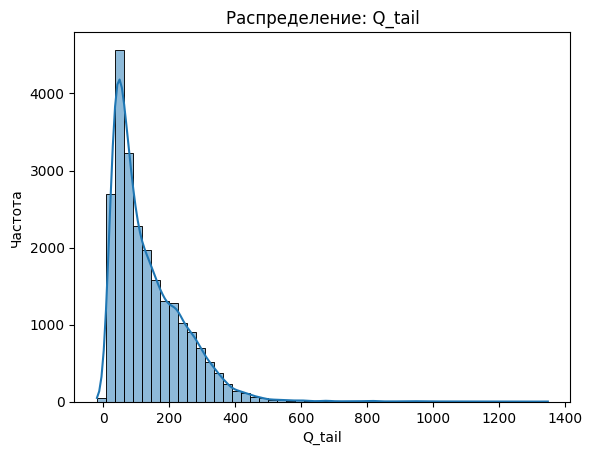

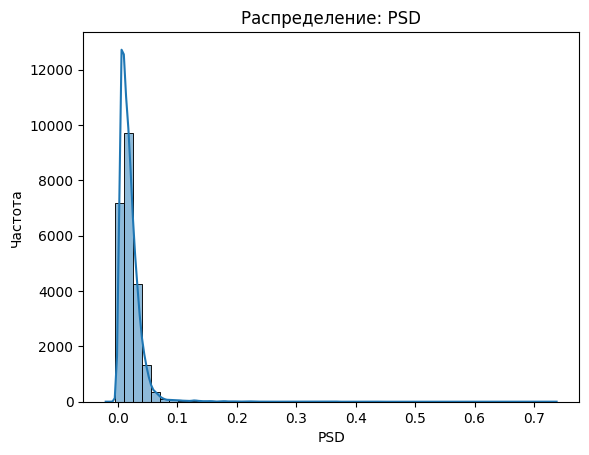

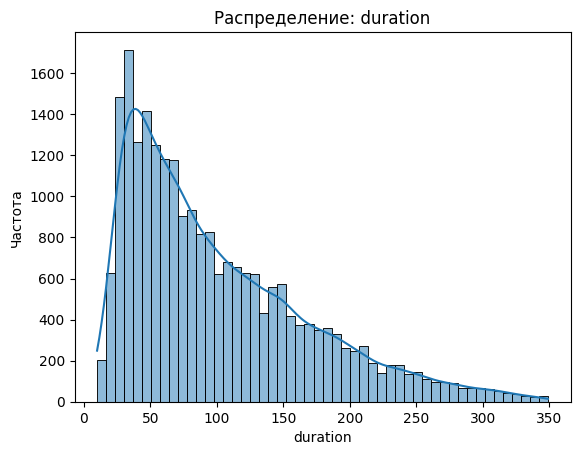

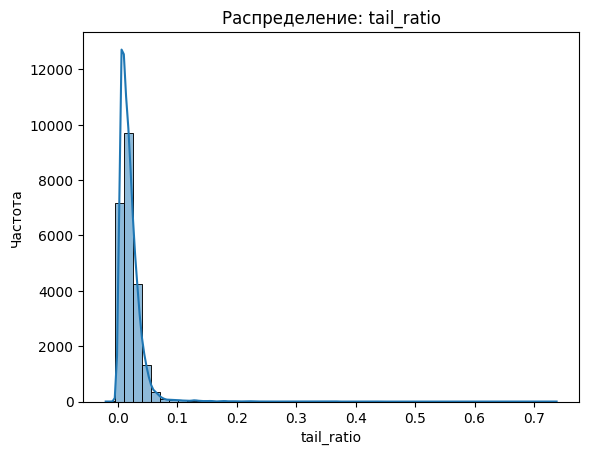

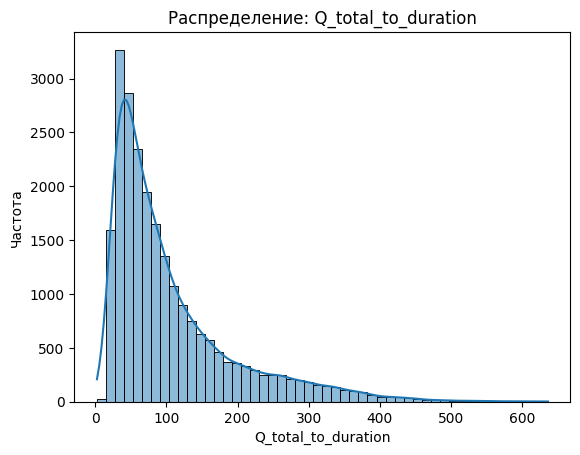

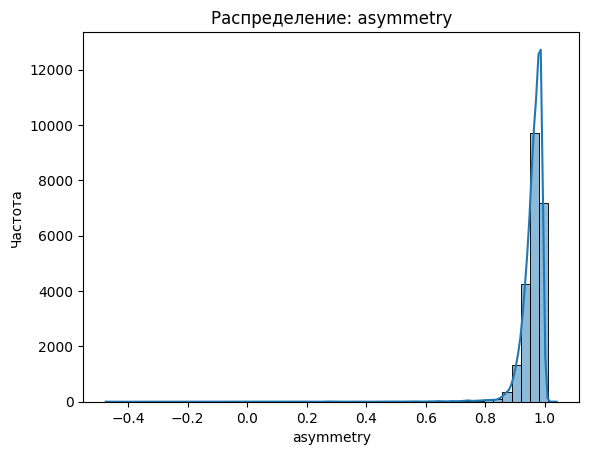

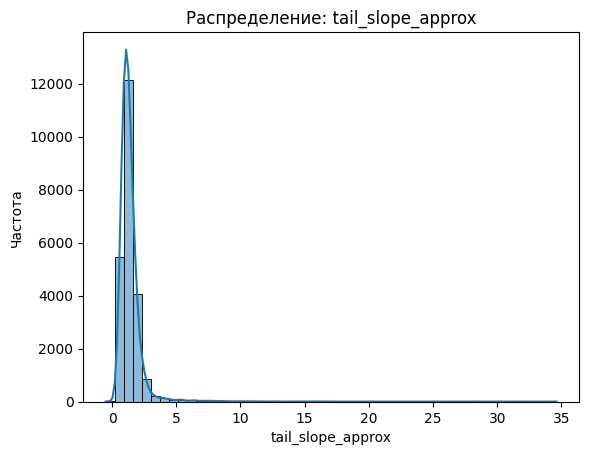

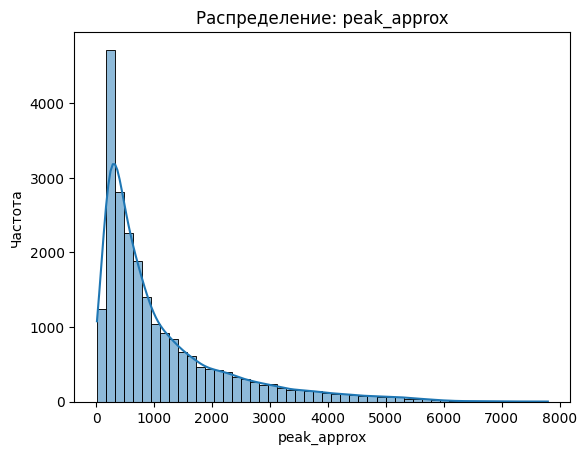

In [7]:
# 2. Распределения
features = [
    'Q_tail', 'PSD', 'duration',
    'tail_ratio', 'Q_total_to_duration', 'asymmetry',
    'tail_slope_approx', 'peak_approx'
]

for col in features:
    plt.figure()
    sns.histplot(processed_df[col], kde=True, bins=50)
    plt.title(f'Распределение: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

Видим сильную скошенность по Q_total и Q_tail. Для того, чтобы использовать его в анализе прологорифмируем его (записали в столбцы 'log_Q_total', 'log_Q_tail')

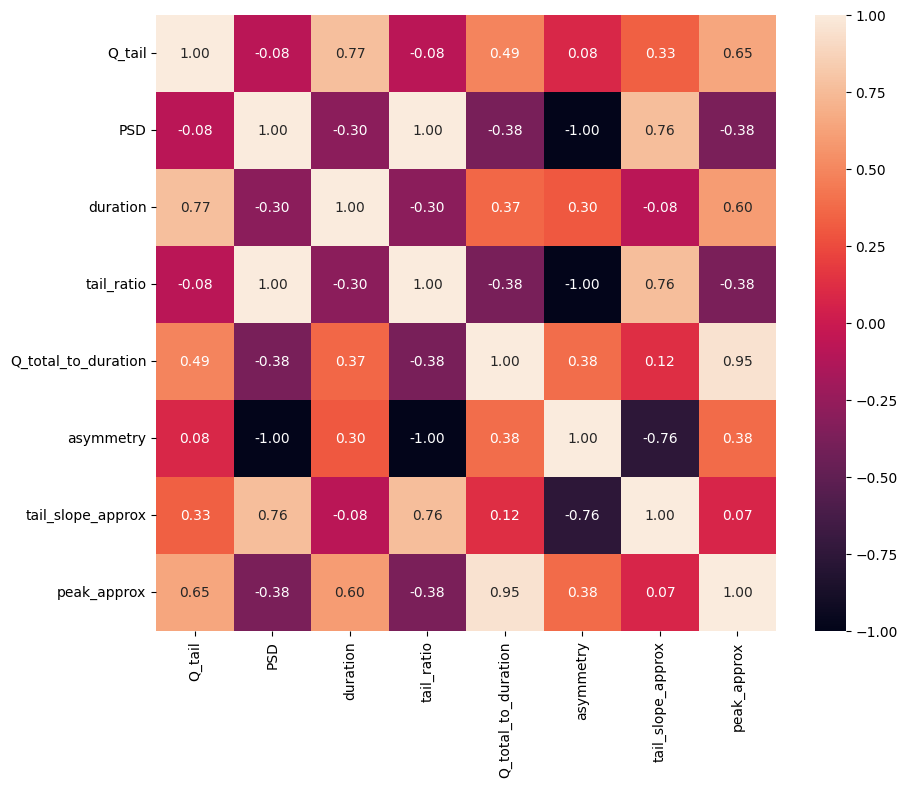

In [8]:
# 3. Корреляционная матрица
plt.figure(figsize=(10, 8))
corr = processed_df[features].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()


Видим сильную корреляцию asymmetry и Q_total_to_duration, следовательно, исключим ее из дальнейшего анализа

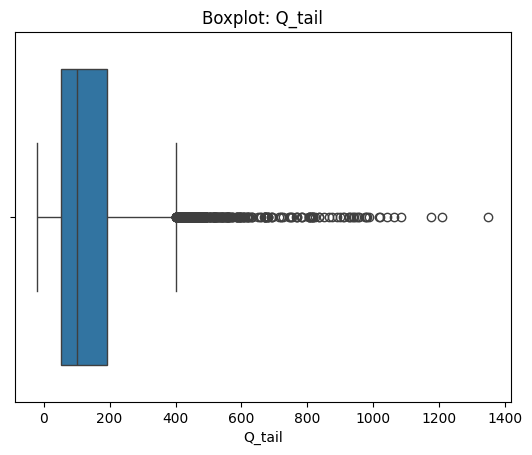

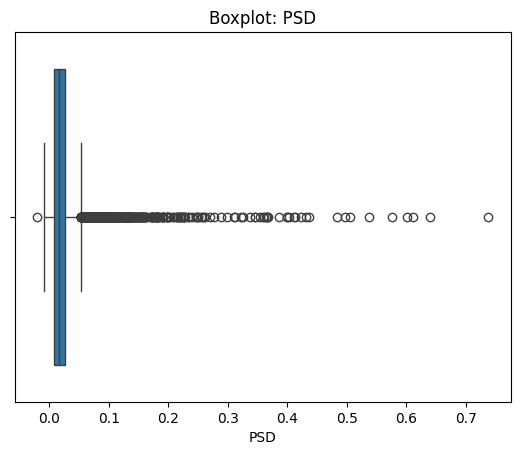

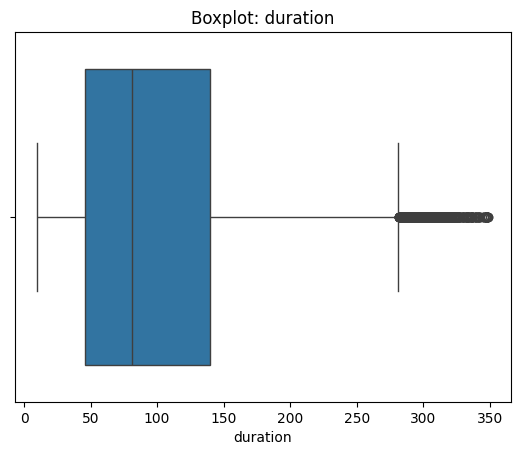

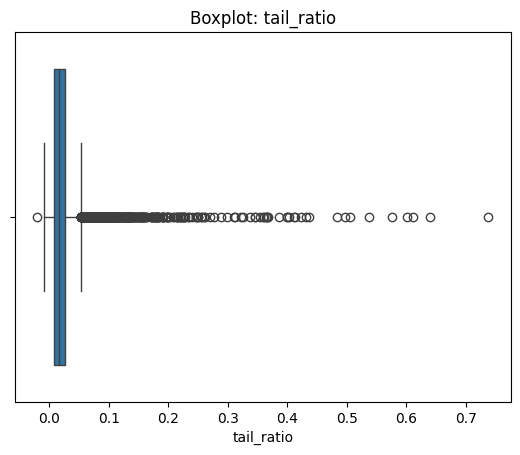

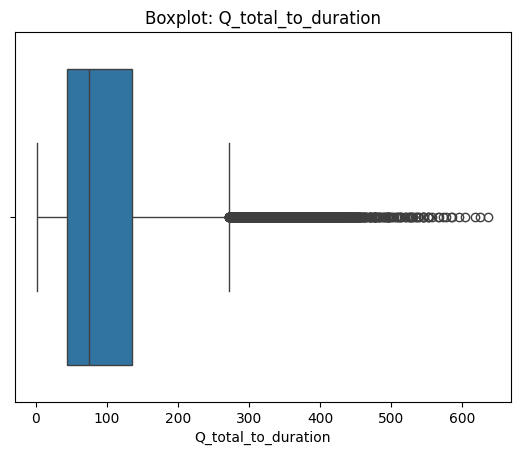

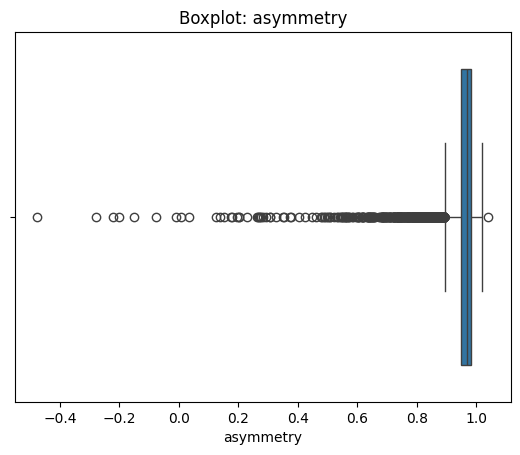

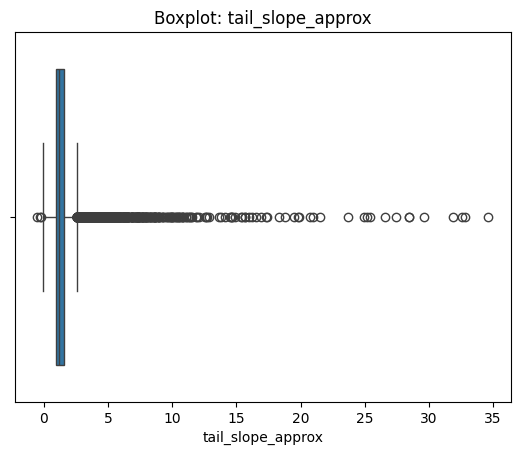

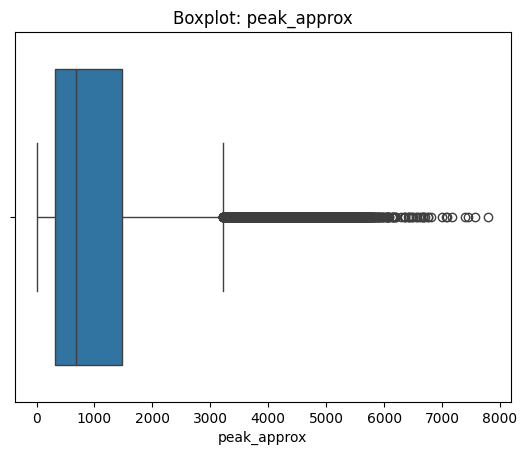

In [9]:
# Выбросы
for col in features:
    plt.figure()
    sns.boxplot(x=processed_df[col])
    plt.title(f'Boxplot: {col}')
    plt.show()


Видим, что все показатели имеют таким образом какие-либо выбросы. Следует это учитывать в дальнейшем анализе

# Моделирование

In [10]:
processed_df['cluster'] = [np.nan]*len(processed_df)

processed_df.loc[processed_df['PSD'].isna()==True, 'cluster'] = 2

In [11]:
df_for_clusterisation = processed_df.loc[processed_df['PSD'].isna()!=True].copy()
df_for_clusterisation

,0,1,2,3,4,5,6,7,8,9,...,PSD,duration,log_Q_total,log_Q_tail,tail_ratio,Q_total_to_duration,asymmetry,tail_slope_approx,peak_approx,cluster
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,0.025372,95.0,8.318742,4.653960,0.025372,43.147368,0.949256,1.094737,420.548483,NaN
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,0.007877,113.0,9.387147,4.553877,0.007877,105.601769,0.984245,0.831858,1122.562107,NaN
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,0.004585,71.0,9.702533,4.330733,0.004585,230.394363,0.990830,1.056338,1941.337206,NaN
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,0.020399,93.0,8.358432,4.477337,0.020399,45.860215,0.959203,0.935484,442.259852,NaN
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,0.007861,64.0,9.334591,4.499810,0.007861,176.906247,0.984278,1.390625,1415.249823,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23474,14826,14827,14825,14818,14825,14827,14827,14823,14823,14823,...,0.007874,61.0,8.102586,3.295837,0.007874,54.131147,0.984252,0.426230,422.777723,NaN
23475,14824,14823,14819,14828,14819,14824,14824,14823,14824,14821,...,0.006294,280.0,10.713617,5.648974,0.006294,160.582142,0.987412,1.010714,2687.053037,NaN
23476,14822,14822,14824,14820,14823,14828,14823,14824,14820,14824,...,0.011473,193.0,10.550041,6.084499,0.011473,197.813470,0.977055,2.269430,2748.112375,NaN
23477,14824,14823,14824,14822,14821,14824,14820,14822,14828,14827,...,0.015088,135.0,9.364434,5.176150,0.015088,86.407407,0.969824,1.303704,1003.963263,NaN


## Кластеризация GMM с использованием Feature Engineering

In [12]:
features = ['PSD', 'duration', 'log_Q_total', 
                'tail_ratio', 'Q_total_to_duration', 
                'tail_slope_approx', 'peak_approx']
X = df_for_clusterisation.loc[:, features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# GMM на 2 компоненты
gmm = GaussianMixture(n_components=2, random_state=42, max_iter=200)
gmm.fit(X_scaled)

probs = gmm.predict_proba(X_scaled)
max_probs = probs.max(axis=1)
labels = gmm.predict(X_scaled)

# Объявим аномальные сигналы
cluster_result = np.full(len(df), 2)  # все — аномальные по умолчанию
cluster_result = np.where(max_probs < 0.7, 2, labels)

df_for_clusterisation['cluster'] = cluster_result

In [13]:
final_df = pd.concat([df_for_clusterisation, processed_df.loc[processed_df['cluster'].isna()==False]])
final_df['cluster'].astype(int).to_csv('result.csv')

In [14]:
processed_df.loc[processed_df['cluster'].isna()==False]

,0,1,2,3,4,5,6,7,8,9,...,PSD,duration,log_Q_total,log_Q_tail,tail_ratio,Q_total_to_duration,asymmetry,tail_slope_approx,peak_approx,cluster
66,14820,14819,14817,14823,14820,14820,14821,14820,14825,14820,...,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
99,14823,14827,14824,14823,14815,14820,14827,14824,14820,14819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
186,14819,14820,14823,14823,14817,14824,14822,14820,14822,14818,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
261,14819,14817,14824,14820,14818,14824,14820,14821,14820,14818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
290,14826,14819,14823,14824,14824,14822,14823,14825,14822,14821,...,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23148,14823,14824,14823,14824,14820,14822,14824,14824,14823,14820,...,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
23375,14820,14823,14824,14823,14828,14822,14820,14819,14824,14824,...,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
23378,14822,14826,14824,14830,14820,14823,14823,14826,14827,14823,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
23401,14820,14823,14821,14824,14823,14823,14826,14824,14821,14827,...,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


Результат данного решения на Kaggle составил 0,3998 accuracy 

## Кластеризация с использованием GMM+PCA

In [17]:
features = ['PSD', 'Q_tail', 'duration', 'log_Q_total', 
                'tail_ratio',
                'tail_slope_approx', 'peak_approx']

X = df_for_clusterisation.loc[:, features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_pca)
probs = gmm.predict_proba(X_pca)
labels = gmm.predict(X_pca)
max_probs = probs.max(axis=1)

pred_labels = np.full(len(df_for_clusterisation), 2)
confident = max_probs >= 0.7
pred_labels = np.where(confident, labels, 2)

df_for_clusterisation['cluster'] = pred_labels

print(f'Explained variance by PCA (2 components): {pca.explained_variance_ratio_.sum():.2%}')
print("Cluster sizes:", dict(pd.Series(pred_labels).value_counts()))

Explained variance by PCA (2 components): 87.49%
Cluster sizes: {0: np.int64(21732), 1: np.int64(893), 2: np.int64(558)}


In [16]:
final_df = pd.concat([df_for_clusterisation, processed_df.loc[processed_df['cluster'].isna()==False]])
final_df['cluster'].astype(int).to_csv('with_pca_result.csv')